In [1]:
import torch
import torch.nn as nn
from torchvision.models import resnet18
import os
import xml.etree.ElementTree as ET
import cv2
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torchsummary import  summary

In [2]:
labmap = {0: "n02089078-black-and-tan_coonhound",
          1: "n02091831-Saluki",
          2: "n02092002-Scottish_deerhound",
          3: "n02095314-wire-haired_fox_terrier"}

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = self.load_images()

    def load_images(self):
        images = []
        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_path):
                image_path = os.path.join(class_path, filename)
                images.append((image_path, self.class_to_idx[class_name]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


root_folder = '../DataSet/ProcessedDatasets/'
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])

dog_dataset = CustomDataset(root_folder, transform=transform)

batch_size = 16
data_loader = DataLoader(dog_dataset, batch_size=batch_size, shuffle=True)

# Load the pre-trained ResNet-18 model
resnet_model = resnet18(pretrained=True)
# Remove the final fully connected layer
resnet_model = torch.nn.Sequential(*(list(resnet_model.children())[:-1]))
resnet_model = resnet_model.to('cuda')
# Set the model to evaluation mode
resnet_model.eval()


c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [3]:

summary(resnet_model,(3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [4]:
batch_size = 32
data_loader = DataLoader(dog_dataset, batch_size=batch_size, shuffle=False)

# Extract features using the pre-trained ResNet-18 model
all_features = []
all_labels = []


with torch.no_grad():
    for images, labels in data_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        features = resnet_model(images)
        all_features.append(features.cpu().squeeze().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate features and labels
all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [5]:
pca = PCA(n_components=2)
principalComponents_dog = pca.fit_transform(all_features)

c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


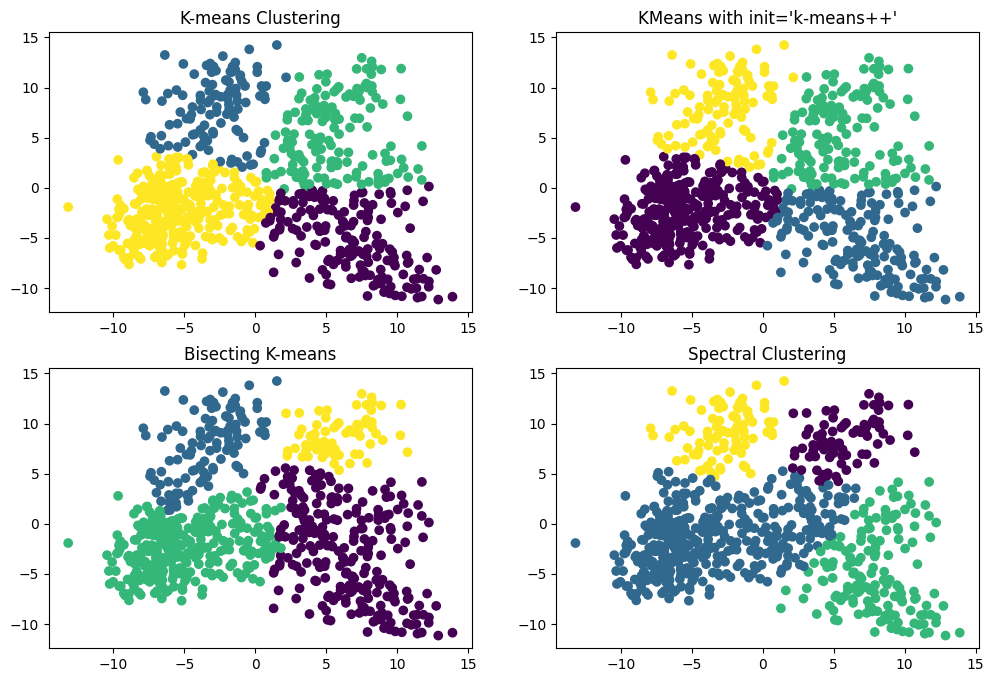

In [6]:
from sklearn.cluster import KMeans, SpectralClustering, Birch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# (a) K-means clustering
kmeans = KMeans(n_clusters=4, init='random')
kmeans_labels = kmeans.fit_predict(principalComponents_dog)

# (b) KMeans with init='k-means++'
kmeans_pp = KMeans(n_clusters=4, init='k-means++')
kmeans_pp_labels = kmeans_pp.fit_predict(principalComponents_dog)

# (c) Bisecting K-means
bisecting_kmeans = Birch(n_clusters=4, threshold=0.01, branching_factor=50)
bisecting_kmeans_labels = bisecting_kmeans.fit_predict(principalComponents_dog)

# (d) Spectral clustering
spectral_clustering = SpectralClustering(n_clusters=4)
spectral_labels = spectral_clustering.fit_predict(principalComponents_dog)

# Plot the results
plt.figure(figsize=(12, 8))

# Plot K-means clustering
plt.subplot(221)
plt.scatter(principalComponents_dog[:, 0], principalComponents_dog[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-means Clustering')

# Plot KMeans with init='k-means++'
plt.subplot(222)
plt.scatter(principalComponents_dog[:, 0], principalComponents_dog[:, 1], c=kmeans_pp_labels, cmap='viridis')
plt.title('KMeans with init=\'k-means++\'')

# Plot Bisecting K-means
plt.subplot(223)
plt.scatter(principalComponents_dog[:, 0], principalComponents_dog[:, 1], c=bisecting_kmeans_labels, cmap='viridis')
plt.title('Bisecting K-means')

# Plot Spectral clustering
plt.subplot(224)
plt.scatter(principalComponents_dog[:, 0], principalComponents_dog[:, 1], c=spectral_labels, cmap='viridis')
plt.title('Spectral Clustering')

plt.show()


In [7]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import fowlkes_mallows_score, silhouette_score

# (e) DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(principalComponents_dog)

# (f) Agglomerative clustering
# (f) Single link (MIN)
single_link = AgglomerativeClustering(n_clusters=4, linkage='single')
single_link_labels = single_link.fit_predict(principalComponents_dog)

# (g) Complete link (MAX)
complete_link = AgglomerativeClustering(n_clusters=4, linkage='complete')
complete_link_labels = complete_link.fit_predict(principalComponents_dog)

# (h) Group Average
group_average = AgglomerativeClustering(n_clusters=4, linkage='average')
group_average_labels = group_average.fit_predict(principalComponents_dog)

# (i) Ward's method
ward = AgglomerativeClustering(n_clusters=4, linkage='ward')
ward_labels = ward.fit_predict(principalComponents_dog)

# Clustering evaluation metrics
def evaluate_clustering(labels, true_labels):
    fowlkes_mallows = fowlkes_mallows_score(true_labels, labels)
    silhouette = silhouette_score(principalComponents_dog, labels)
    return fowlkes_mallows, silhouette

# Ground truth labels (assuming you have them)
true_labels = all_labels

# Evaluate DBSCAN
dbscan_scores = evaluate_clustering(dbscan_labels, true_labels)



In [8]:

# Evaluate Agglomerative clustering methods
single_link_scores = evaluate_clustering(single_link_labels, true_labels)
complete_link_scores = evaluate_clustering(complete_link_labels, true_labels)
group_average_scores = evaluate_clustering(group_average_labels, true_labels)
ward_scores = evaluate_clustering(ward_labels, true_labels)

# Print the evaluation scores
print("DBSCAN Scores (Fowlkes-Mallows, Silhouette):", dbscan_scores)
print("Single Link Scores (Fowlkes-Mallows, Silhouette):", single_link_scores)
print("Complete Link Scores (Fowlkes-Mallows, Silhouette):", complete_link_scores)
print("Group Average Scores (Fowlkes-Mallows, Silhouette):", group_average_scores)
print("Ward Scores (Fowlkes-Mallows, Silhouette):", ward_scores)

# Rank methods based on Fowlkes-Mallows index
methods_fm_rank = sorted([(dbscan_scores[0], 'DBSCAN'),
                          (single_link_scores[0], 'Single Link'),
                          (complete_link_scores[0], 'Complete Link'),
                          (group_average_scores[0], 'Group Average'),
                          (ward_scores[0], "Ward's Method")], reverse=True)

# Rank methods based on Silhouette Coefficient
methods_silhouette_rank = sorted([(dbscan_scores[1], 'DBSCAN'),
                                 (single_link_scores[1], 'Single Link'),
                                 (complete_link_scores[1], 'Complete Link'),
                                 (group_average_scores[1], 'Group Average'),
                                 (ward_scores[1], "Ward's Method")], reverse=True)

# Print the rankings
print("\nRankings based on Fowlkes-Mallows Index:")
for rank, method in enumerate(methods_fm_rank, 1):
    print(f"{rank}. {method[1]}")

print("\nRankings based on Silhouette Coefficient:")
for rank, method in enumerate(methods_silhouette_rank, 1):
    print(f"{rank}. {method[1]}")

DBSCAN Scores (Fowlkes-Mallows, Silhouette): (0.39104721904591266, -0.41385117)
Single Link Scores (Fowlkes-Mallows, Silhouette): (0.5040685805968986, -0.16556796)
Complete Link Scores (Fowlkes-Mallows, Silhouette): (0.5012423920720506, 0.3817501)
Group Average Scores (Fowlkes-Mallows, Silhouette): (0.5117577274398017, 0.44211775)
Ward Scores (Fowlkes-Mallows, Silhouette): (0.5476597520531451, 0.42495418)

Rankings based on Fowlkes-Mallows Index:
1. Ward's Method
2. Group Average
3. Single Link
4. Complete Link
5. DBSCAN

Rankings based on Silhouette Coefficient:
1. Group Average
2. Ward's Method
3. Complete Link
4. Single Link
5. DBSCAN
